總績效 0.0114 
交易次數 182 
平均績效 0.0001 
平均持有天數 7 天
勝率 0.51 
平均獲利 0.0172 
平均虧損 -0.0178 
賺賠比 0.9639 
期望值 0.0035 
獲利平均持有天數 7 天
虧損平均持有天數 8 天
最大連續虧損 -0.1158
最大資金回落 0.2671


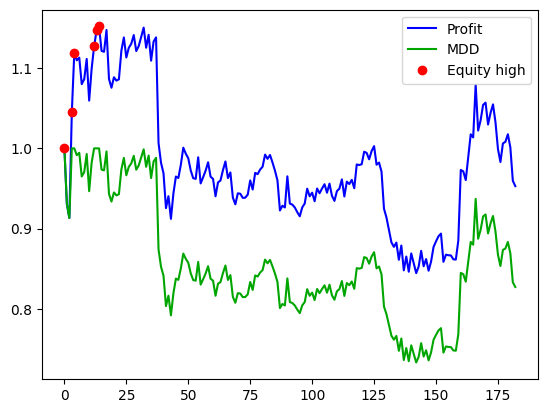

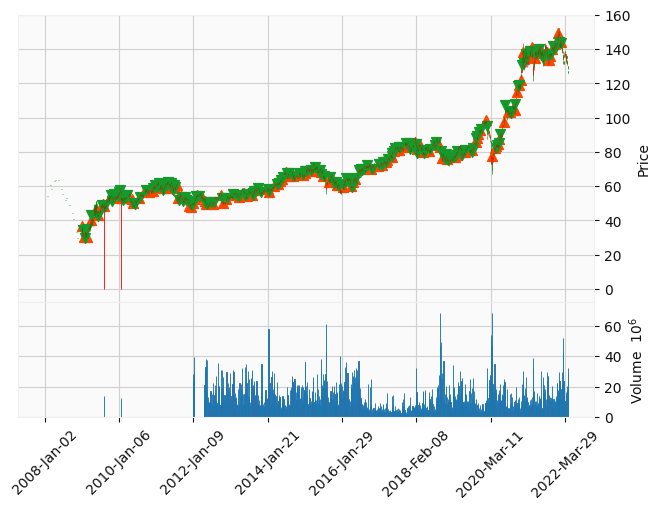

In [1]:
# 載入必要套件
from Data import getDataFM
from BackTest import ChartTrade, Performance
import pandas as pd

# 取得回測資料
prod = "0050"
data = getDataFM(prod, "2007-01-01", "2022-05-01")

# 初始部位
position = 0
trade = pd.DataFrame()
# 開始回測
for i in range(data.shape[0] - 1):
    # 取得策略會應用到的變數
    c_time = data.index[i]
    c_low = data.loc[c_time, "low"]
    c_high = data.loc[c_time, "high"]
    c_close = data.loc[c_time, "close"]
    c_open = data.loc[c_time, "open"]
    # 取下一期資料做為進場資料
    n_time = data.index[i + 1]
    n_open = data.loc[n_time, "open"]

    # 進場程序
    if position == 0:
        # 進場邏輯
        if c_close > c_open and (c_close - c_open) * 2 < (c_open - c_low):
            position = 1
            order_i = i
            order_time = n_time
            order_price = n_open
            order_unit = 1
    # 出場程序
    elif position == 1:
        # 出場邏輯
        if i > order_i + 3 and c_close > c_open:
            position = 0
            cover_time = n_time
            cover_price = n_open
            # 交易紀錄
            trade = trade._append(
                pd.Series(
                    [
                        prod,
                        "Buy",
                        order_time,
                        order_price,
                        cover_time,
                        cover_price,
                        order_unit,
                    ]
                ),
                ignore_index=True,
            )

# 績效分析
Performance(trade, "ETF")
# 繪製K線圖與交易明細
ChartTrade(data, trade)
